In [1]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layer

from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate

2022-09-29 14:37:24.102358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import collections
import sys, os, datetime

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score, plot_confusion_matrix

import seaborn as sns
import tensorboard

from tqdm import tqdm

import helper_functions

pd.options.display.max_columns = None

In [3]:
filename = '../data/preprocessed_data.pickle'
figure_path = '../report/figures/autoencoder/'

input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [4]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [5]:
x_train

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
31805,80,47142,3,4,442,871,436,0,147.333333,250.010666,859,0,217.75,427.509357,27852.021550,1.484875e+02,7.857000e+03,1.190133e+04,23344,4,23294,11647.0,1.622103e+04,23117,177,24047,8.015667e+03,1.344935e+04,23543,4,0,0,0,0,72,92,6.363752e+01,84.850028,0,859,164.125000,319.058632,1.017984e+05,0,0,0,1,0,0,0,0,1,187.571429,147.333333,217.75,72,0,0,0,0,0,0,3,442,4,871,8192,31,2,20,0.0,0.0,0,0,0.0,0.0,0,0
60865,51707,3,2,0,0,0,0,0,0.000000,0.000000,0,0,0.00,0.000000,0.000000,6.666667e+05,3.000000e+00,0.000000e+00,3,3,3,3.0,0.000000e+00,3,3,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,6.666667e+05,0.000000,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.00,40,0,0,0,0,0,0,2,0,0,0,5181,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0
173108,54225,83,1,1,0,0,0,0,0.000000,0.000000,0,0,0.00,0.000000,0.000000,2.409639e+04,8.300000e+01,0.000000e+00,83,83,0,0.0,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,32,32,1.204819e+04,12048.192771,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,1,0.000000,0.000000,0.00,32,0,0,0,0,0,0,1,0,1,0,117,33304,0,32,0.0,0.0,0,0,0.0,0.0,0,0
507160,53,30638,2,2,70,134,35,35,35.000000,0.000000,67,67,67.00,0.000000,6658.398068,1.305568e+02,1.021267e+04,1.768626e+04,30635,0,0,0.0,0.000000e+00,0,0,3,3.000000e+00,0.000000e+00,3,3,0,0,0,0,80,64,6.527841e+01,65.278412,35,67,47.800000,17.527122,3.072000e+02,0,0,0,0,0,0,0,0,1,59.750000,35.000000,67.00,80,0,0,0,0,0,0,2,70,2,134,-1,-1,1,40,0.0,0.0,0,0,0.0,0.0,0,0
63403,3120,1,2,0,0,0,0,0,0.000000,0.000000,0,0,0.00,0.000000,0.000000,2.000000e+06,1.000000e+00,0.000000e+00,1,1,1,1.0,0.000000e+00,1,1,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,2.000000e+06,0.000000,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.00,40,0,0,0,0,0,0,2,0,0,0,2559,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,80,30186175,6,4,575,567,575,0,95.833333,234.742767,386,0,141.75,183.833938,37.831888,3.312775e-01,3.354019e+06,9.992310e+06,30000000,3,30200000,6037235.0,1.340000e+07,30000000,3,149889,4.996300e+04,5.637366e+04,111082,4,0,0,0,0,204,136,1.987665e-01,0.132511,0,575,103.818182,198.449398,3.938216e+04,0,0,0,1,0,0,0,0,0,114.200000,95.833333,141.75,204,0,0,0,0,0,0,6,575,4,567,65535,341,1,32,0.0,0.0,0,0,0.0,0.0,0,0
220455,80,100165663,6,6,350,11595,332,0,58.333333,134.100957,10136,0,1932.50,4060.245892,119.252443,1.198015e-01,9.105969e+06,3.010000e+07,100000000,4,10000000

In [6]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [7]:
input_dim = x_train.shape[1]

batch_size = 512
latent_dim = 4 
max_epochs = 50 

In [8]:
input_data = Input(shape=(input_dim,), name='encoder_input')

encoder = Dense(96,activation='tanh', name='encoder_1')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(48,activation='tanh', name='encoder_5')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(28,activation='tanh', name='encoder_6')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16,activation='tanh', name='encoder_7')(encoder)
encoder = Dropout(.1)(encoder)

latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

encoder_model = Model(input_data, latent_encoding)


2022-09-29 14:37:27.990593: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-29 14:37:27.991419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-29 14:37:28.018298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 14:37:28.018470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2022-09-29 14:37:28.018482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-29 14:37:28.019826: I tensorflow/stream_executor/platfo

In [9]:


decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(28, activation='tanh', name='decoder_2')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(48, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_5')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_6')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(96, activation='tanh', name='decoder_7')(decoder)
decoder = Dropout(.1)(decoder)

reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)

In [10]:
autoencoder_model = Model(input_data, reconstructed_data)

In [11]:
opt = optimizers.Adam(lr=.000001)

autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

In [12]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)

train_history = autoencoder_model.fit(x_train, x_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[tensorboard_callback])

2022-09-29 14:37:28.790266: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 661722984 exceeds 10% of free system memory.
2022-09-29 14:37:29.189697: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 661722984 exceeds 10% of free system memory.
2022-09-29 14:37:29.419896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-29 14:37:29.436392: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3601050000 Hz


Epoch 1/50
  14/4143 [..............................] - ETA: 16s - loss: 0.0935 - accuracy: 0.0072  

2022-09-29 14:37:29.991511: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


4143/4143 [==============================] - 15s 3ms/step - loss: 0.0805 - accuracy: 0.0596 - val_loss: 0.0346 - val_accuracy: 0.3537
Epoch 2/50
4143/4143 [==============================] - 13s 3ms/step - loss: 0.0466 - accuracy: 0.1567 - val_loss: 0.0200 - val_accuracy: 0.3537
Epoch 3/50
4143/4143 [==============================] - 14s 3ms/step - loss: 0.0328 - accuracy: 0.1347 - val_loss: 0.0172 - val_accuracy: 0.3537
Epoch 4/50
4143/4143 [==============================] - 13s 3ms/step - loss: 0.0261 - accuracy: 0.1156 - val_loss: 0.0150 - val_accuracy: 0.3537
Epoch 5/50
4143/4143 [==============================] - 13s 3ms/step - loss: 0.0217 - accuracy: 0.1027 - val_loss: 0.0132 - val_accuracy: 0.0165
Epoch 6/50
4143/4143 [==============================] - 13s 3ms/step - loss: 0.0188 - accuracy: 0.0980 - val_loss: 0.0113 - val_accuracy: 0.3497
Epoch 7/50
4143/4143 [==============================] - 13s 3ms/step - loss: 0.0165 - accuracy: 0.1123 - val_loss: 0.0097 - val_accuracy: 0.3

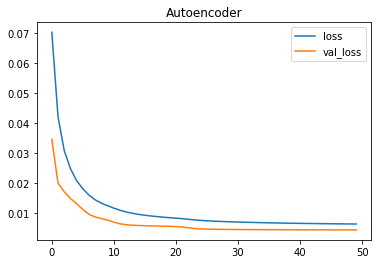

In [13]:
helper_functions.plot_loss(train_history, figure_path + 'loss_autoencoder.png', 'Autoencoder')

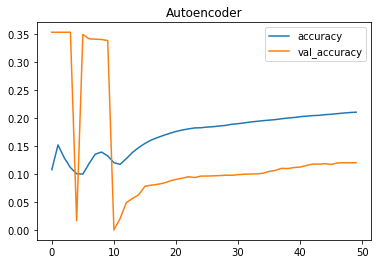

In [14]:
helper_functions.plot_accuracy(train_history, figure_path + 'accuracy_autoencoder.png', 'Autoencoder')

In [15]:
x_test_recon = autoencoder_model.predict(x_test)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})

In [16]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'BENIGN')[0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

In [17]:
binary_labels = convert_label_to_binary(le, y_test)

# add the binary labels to our anomaly dataframe
anomaly_data['binary_labels'] = binary_labels

# let's check if the reconstruction statistics are different for labeled anomalies
anomaly_data.groupby(by='binary_labels').describe()

recon_score                                                    \
                    count      mean       std       min       25%       50%   
binary_labels                                                                 
0                567586.0  0.003769  0.005905  0.000243  0.000251  0.001510   
1                139383.0  0.007606  0.006911  0.000249  0.001954  0.005535   

                                   
                    75%       max  
binary_labels                      
0              0.004770  0.135575  
1              0.010603  0.086718

In [18]:
binary_labels

array([0, 0, 0, ..., 0, 0, 1])

In [19]:
reconstruction_scores

array([0.00263108, 0.00363687, 0.00237088, ..., 0.00024713, 0.00348892,
       0.00129723], dtype=float32)

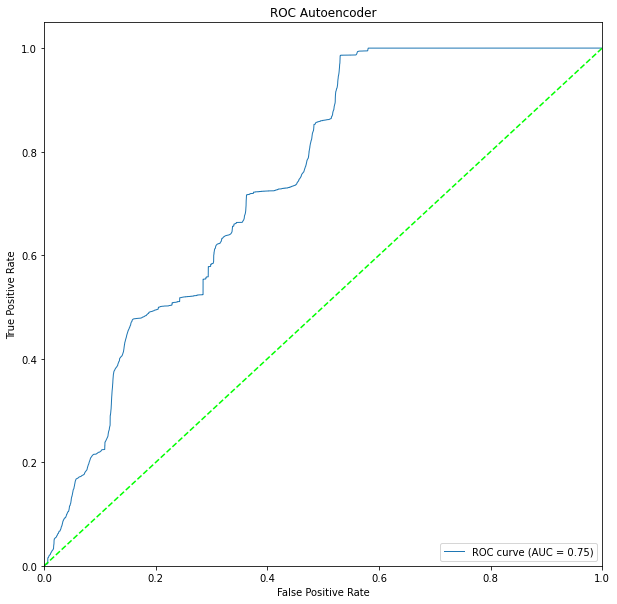

In [20]:
fpr, tpr, thresholds = roc_curve(binary_labels, reconstruction_scores)
roc_auc = auc(fpr, tpr)

helper_functions.plot_roc(tpr, fpr, roc_auc, figure_path + 'roc_autoencoder.png', 'Autoencoder')

In [21]:
threshold_idx = np.argmax(tpr - fpr)
threshold = thresholds[threshold_idx]
print(threshold)

0.0012817273


In [22]:
pred_labels = (reconstruction_scores > threshold).astype(int)

results = confusion_matrix(binary_labels, pred_labels) 


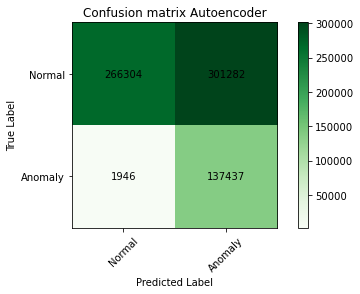

In [23]:
helper_functions.plot_confusion_matrix(results, figure_path + 'confusion_autoencoder.png', 'Autoencoder')